### Intro to PyTorch - Udacity

1. `Reshaping Tensors`
2. `Numpy to Torch and back`
3. `Getting Datasets`
4. `2-Layer NN from SCRATCH`
5. `Softmax from SCRATCH`
    * Broadcasting in Numpy INTUITION
    
    
6. `Creating ready-made NN( inheriting torch.nn.Module class )`
7. `Creating ready-made NN( using nn.Sequential )`
8. `Losses in PyTorch`
9. `Autograd`

### 1. Reshaping Tensors

Let **weights** be a tensor

* `weights.reshape(a, b)` will return a new tensor with the same data(points to the same memory location) as `weights` with size `(a, b)` sometimes, and sometimes a clone, as in it copies the data to another part of memory.
* `weights.resize_(a, b)` returns the same tensor with a different shape. However, if the new shape results in fewer elements than the original tensor, some elements will be removed from the tensor (but not from memory). If the new shape results in more elements than the original tensor, new elements will be uninitialized in memory. Here I should note that the underscore at the end of the method denotes that this method is performed **in-place**. Here is a great forum thread to [read more about in-place operations](https://discuss.pytorch.org/t/what-is-in-place-operation/16244) in PyTorch.
* `weights.view(a, b)` will return a new tensor with the same data as `weights` with size `(a, b)`.


In [8]:
import torch

x = torch.randn(1)
y = torch.randn(1)

print(x, y)
print(f'id(x): {id(x)}, id(y): {id(y)}')

tensor([0.8947]) tensor([-0.3227])
id(x): 2204467581432, id(y): 2204497406712


In [9]:
x = x + y # Normal operation 
print(f'x = {x} id(x) = {id(x)}') # New location for x

x = tensor([0.5720]) id(x) = 2204497407864


In [10]:
x += y # inplace operation
print(f'x = {x} id(x) = {id(x)}') # existing location used(in-place)

x = tensor([0.2493]) id(x) = 2204497407864


In [11]:
x.add_(y) # inplace operation
print(f'x = {x} id(x) = {id(x)}') # existing location used(in-place)

x = tensor([-0.0734]) id(x) = 2204497407864


**Inplace operations in pytorch are always postfixed with a _ , like .add_() or .scatter_(). Python operations like += or *= are also inplace operations.**
<hr>

### 2. Numpy to Torch and back

Special bonus section! PyTorch has a great feature for converting between Numpy arrays and Torch tensors. To create a tensor from a Numpy array, use `torch.from_numpy()`. To convert a tensor to a Numpy array, use the `.numpy()` method.

In [12]:
import numpy as np
a = np.random.rand(4,3)
a

array([[0.62610611, 0.73824629, 0.68162487],
       [0.45799142, 0.81512616, 0.9046208 ],
       [0.13016165, 0.132936  , 0.03448641],
       [0.46551398, 0.73371913, 0.05358193]])

In [13]:
b = torch.from_numpy(a)
b

tensor([[0.6261, 0.7382, 0.6816],
        [0.4580, 0.8151, 0.9046],
        [0.1302, 0.1329, 0.0345],
        [0.4655, 0.7337, 0.0536]], dtype=torch.float64)

In [14]:
b.numpy()

array([[0.62610611, 0.73824629, 0.68162487],
       [0.45799142, 0.81512616, 0.9046208 ],
       [0.13016165, 0.132936  , 0.03448641],
       [0.46551398, 0.73371913, 0.05358193]])

The memory is shared between the Numpy array and Torch tensor, so if you change the values in-place of one object, the other will change as well.

In [15]:
# Multiply PyTorch Tensor by 2, in place
b.mul_(2)

tensor([[1.2522, 1.4765, 1.3632],
        [0.9160, 1.6303, 1.8092],
        [0.2603, 0.2659, 0.0690],
        [0.9310, 1.4674, 0.1072]], dtype=torch.float64)

In [16]:
# Numpy array matches new values from Tensor
a

array([[1.25221221, 1.47649258, 1.36324974],
       [0.91598285, 1.63025232, 1.8092416 ],
       [0.26032331, 0.26587199, 0.06897282],
       [0.93102797, 1.46743827, 0.10716386]])

<hr>

### 3. Getting datasets

In [151]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
# transforms.Normalize((mean_pixel), (standard_deviation_pixel))
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
print(len(trainloader))

# Download and load the test data => train=False
testset = datasets.MNIST('~/.pytorch/MNIST_data', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size=64)
print(len(testloader))

938
157


We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. Later, we'll use this to loop through the dataset for training, like

```python
for image, label in trainloader:
    ## do things with images and labels
```

You'll notice I created the `trainloader` with a batch size of 64, and `shuffle=True`. The batch size is the number of images we get in one iteration from the data loader and pass through our network, often called a *batch*. And `shuffle=True` tells it to shuffle the dataset every time we start going through the data loader again. But here I'm just grabbing the first batch so we can check out the data. We can see below that `images` is just a tensor with size `(64, 1, 28, 28)`. So, 64 images per batch, 1 color channel, and 28x28 images.

In [18]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [19]:
inputs = images.view(images.shape[0], -1)
inputs.shape

torch.Size([64, 784])

### 4. 2-Layer NN from SCRATCH

Build a multi-layer network with 784 input units, 256 hidden units, and 10 output units using random tensors for the weights and biases. For now, use a sigmoid activation for the hidden layer and leave the output without one.

In [20]:
## Your solution
np.random.seed(7)

def activation(x):
    return 1 / (1 + torch.exp(-x)) # or np.exp(-x)

# Flatten the input image
inputs = images.view(images.shape[0], -1)# or images.view(64, 784)

# Set network layer sizes
n_input = inputs.shape[1] # 784
n_hidden = 256
n_output = 10

# Create parameters
W1 = torch.randn(n_input, n_hidden) # weights for the hidden layer- 784X256
W2 = torch.randn(n_hidden, n_output) # weights for the output layer- 256X10

B1 = torch.randn(1, n_hidden) # biases for the hidden layer- 1X256
B2 = torch.randn(1, n_output) # biases for the output layer- 1X10

# output of hidden layer- 64X256 ie 1X256 values for 64 images in the batch
# torch.mm(inputs, W1)- 64X256
# even though B1 is of shape 1X256, it broadcasts to 64X256 when made to add with a 64X256 matrix
h = activation(torch.mm(inputs, W1) + B1) 

# torch.mm(h, W2)- 64X10
# B2 broadcasts from 1X10 to 64X10 on addition with a 64X10 matrix
out = torch.mm(h, W2) + B2 # network output- 64X10 ie 10 output values for each of 64 images

print(out.shape)
print(out)

torch.Size([64, 10])
tensor([[ 1.2275e+00,  1.7868e+01, -3.3610e+00,  9.6572e+00, -4.4323e+00,
          2.3538e+00, -1.7093e+01,  1.1102e+01,  7.5253e+00,  6.0052e+00],
        [ 1.9197e+00,  3.9145e+00, -4.1184e+00,  1.3343e+01, -1.7035e+01,
         -7.0955e+00, -2.2273e+01,  6.2673e+00, -9.8147e-01,  1.0414e+01],
        [ 8.1331e+00,  1.6488e+01, -2.4356e-01,  7.5493e+00, -7.8329e+00,
          7.8338e+00, -9.8890e+00, -3.9259e+00,  9.7671e+00, -1.7121e+00],
        [-8.2881e+00,  8.3918e+00,  2.4722e+00,  1.5421e+01, -5.5535e+00,
         -1.6099e+01, -1.6919e+01,  8.2451e+00,  7.3715e+00,  6.4537e+00],
        [-3.0707e+00,  1.1511e+01,  5.7331e+00,  9.1911e+00, -1.1015e+01,
         -1.7204e+01, -1.1893e+01,  1.2052e+01,  5.1869e+00,  5.8618e+00],
        [ 8.3273e+00,  2.2861e+01,  5.9417e+00,  4.5867e+00, -8.6057e-01,
          4.6767e-01, -5.5814e+00,  2.7008e+00,  5.5566e+00, -1.2963e+00],
        [ 6.5105e+00,  1.0396e+01,  1.5333e+00,  9.1974e+00, -1.2533e+01,
         -5

          3.5082e+00, -1.5746e+01, -4.7840e+00,  9.5252e+00, -7.5188e+00]])


### 5. Softmax from SCRATCH

In [21]:
def softmax(x):
    num = torch.exp(x)
    den = torch.sum(torch.exp(x), dim=1).view(-1, 1) # change shape from (64, ) to (64, 1).
    return num/den

# Here, out should be the output of the network in the previous excercise with shape (64,10)
probabilities = softmax(out)

# Does it have the right shape? Should be (64, 10)
print(probabilities.shape)
# Does it sum to 1?
print(probabilities.sum(dim=1))

torch.Size([64, 10])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


<img src="../img/softmax-formula.png" width="360px">

The softmax function is calculated by:

1. Find the exponential of the quantity whose softmax score we need to know( `Numerator` )
2. Find the exponential of all the quantities in the group over which we need to find the softmax score( the value of each of the 10 output nodes corresponding to 10 class labels in our case ) and add( $\Sigma_j$ ) it ( `Denominator` )

ie for each value in the group, calculate its exponential and divide it by the sum of exponentials of all values in its group

In our case, we are calculating softmax for the output of all 64 images together. 

Let's start out by viewing how we calculate softmax for a single image.

In [30]:
# from our NN output of 64 images, get output of the first image
# out.shape == [64, 10]
single_image_output = out[0] # or out[0, :] as we require all the 10 column values in the first image

print(single_image_output.shape)
print(single_image_output)

torch.Size([10])
tensor([  1.2275,  17.8675,  -3.3610,   9.6572,  -4.4323,   2.3538, -17.0929,
         11.1017,   7.5253,   6.0052])


In [31]:
# now we can find the softmax scores of the values in the output

# 1. Numerator
# instead of finding the exponential of each of the values in the output, we can find exponential of all values in the
# output using vectorised operations
numerator = torch.exp(single_image_output)

print(numerator.shape)
print(numerator)

torch.Size([10])
tensor([3.4127e+00, 5.7512e+07, 3.4701e-02, 1.5635e+04, 1.1887e-02, 1.0525e+01,
        3.7727e-08, 6.6287e+04, 1.8543e+03, 4.0552e+02])


In [33]:
# 2. Denominator
# we need to find the sum of exponentials of all values in the output
exponentials = torch.exp(single_image_output) # exponential of all values in the output as a tensor
denominator = torch.sum(exponentials) # add all the exponential values to get the sum

print(denominator.shape)
print(denominator)

torch.Size([])
tensor(57596524.)


In [46]:
# Find softmax

softmax = numerator / denominator

# By dividing the numerator tensor of size 10( 1 dimension ) with denominator tensor of size 1 ( 0 dimension or scalar )
# the denominator gets broadcasted to a suitable shape, here to size 10 to make the division happen

# ie by running numerator / denominator actually denominator gets modified to
broadcasted_denominator = torch.Tensor(10).fill_(denominator)

print(f'Broadcasted denominator: {broadcasted_denominator} of shape {broadcasted_denominator.shape}\n')

softmax_broadcasted = numerator / broadcasted_denominator

print(f'Softmax: {softmax}')
print(f'Softmax using denominator of same shape as numerator: {softmax_broadcasted}\n')


equality_check = torch.all(torch.eq(softmax, softmax_broadcasted))
if equality_check == 1:
    print('Both tensors are of same value')
else:
    print('The tensors differ')

Broadcasted denominator: tensor([57596524., 57596524., 57596524., 57596524., 57596524., 57596524.,
        57596524., 57596524., 57596524., 57596524.]) of shape torch.Size([10])

Softmax: tensor([5.9251e-08, 9.9854e-01, 6.0249e-10, 2.7145e-04, 2.0639e-10, 1.8274e-07,
        6.5501e-16, 1.1509e-03, 3.2195e-05, 7.0407e-06])
Softmax using denominator of same shape as numerator: tensor([5.9251e-08, 9.9854e-01, 6.0249e-10, 2.7145e-04, 2.0639e-10, 1.8274e-07,
        6.5501e-16, 1.1509e-03, 3.2195e-05, 7.0407e-06])

Both tensors are of same value


**The takeaway is that given 10 values to softmax, we use all these 10 values to calculate new 10 values**

Now let's get on to calculating softmax over the batch of 64 images
<img src="../img/softmax-formula.png" width="360px">

In [47]:
print(out.shape) # we have 10 class labels each for the 64 images

torch.Size([64, 10])


In [49]:
# 1. Numerator
# Find the exponential of all values we have
numerator = torch.exp(out)
print(num.shape)

torch.Size([64, 10])


In [56]:
# 2. Denominator
# find exponentials
expos = torch.exp(out)
# we need to add the 10 exponentials of each image and 
# get a new tensor with a sum for each image ie a 1D tensor of 64 values
denominator = torch.sum(expos, dim=1) # dim=1 adds up all values in a row, ie for each image
print(denominator.shape)

torch.Size([64])


expos is a `[64, 10]` tensor. `dim=1` in the `torch.sum` function tells it to sum over the values in the second dimension ( first dimenstion is specified by dim=0 ). This results in a `[64]` tensor ie a 1D tensor. 

If we had given `dim=0` as the argument, the returned tensor would had a shape of `[10]`, as the values in the first dimension would be added up.

Incase you are wondering what would happen, if we omit the `dim` argument, it would just sum up all the values in the tensor.

**torch.Size([64])** ~ **numpy (64, )** it is considered to be **(1, 64)** during broadcasting.

So if we divide (64, 10) the numerator with (64, ), python will try to broadcast to make the tensors of same size.
(64, ) to (1, 64) to ?

(64, 10) and (1, 64) can't be broadcasted to equal size and python outputs error.

Now if we reshape (64, ) to (64, 1), the broadcasting goes like this,
(64, 1) to (64, 10)

Now, (64, 10) the numerator and (64, 10) the broadcasted denominator can be divided

<hr>

### 6. Creating ready-made NN( inheriting torch.nn.Module class )

In [23]:
## Your solution here
from torch import nn
import torch.nn.functional as f

# 3 layer NN
class Network3L(nn.Module):
    def __init__(self):
        super().__init__()

        # first fc hidden layer
        self.fc1 = nn.Linear(784, 128)

        # second fc hidden layer
        self.fc2 = nn.Linear(128, 64)

        # fc output layer
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        h1 = F.relu(self.fc1(x)) # output of first hidden layer
        h2 = F.relu(self.fc2(h1)) # output of second hidden layer
        out = F.sigmoid(self.fc3(h2)) # neural network output
        
model = Network3L()
model

Network3L(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [24]:
print(model.fc1.weight.shape, model.fc1.bias.shape)

torch.Size([128, 784]) torch.Size([128])


<hr>

### 7. Creating ready-made NN( using ***nn.Sequential*** )

PyTorch provides a convenient way to build networks like this where a tensor is passed sequentially through operations, `nn.Sequential` ([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)). Using this to build the equivalent network:

In [27]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

# Forward pass through the network and display output
images, labels = next(iter(trainloader)) # get first batch of images and their labels
images.resize_(images.shape[0], 1, 784) # resize images in-place using resize_
ps = model.forward(images[0,:]) # forward pass through our NN, the batch of images

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax()
)


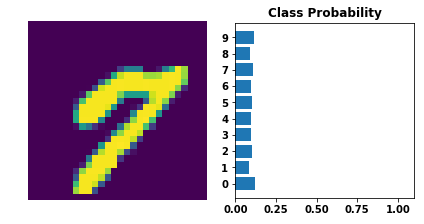

In [60]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(6, 9))

ax[0].imshow(images[0].view(28, 28))
ax[0].axis('off')

ax[1].barh(np.arange(10), ps.data.numpy().squeeze())
ax[1].set_aspect(0.1)
ax[1].set_xlim(0, 1.1)
ax[1].set_yticks(np.arange(10))
ax[1].set_yticklabels(np.arange(10))
ax[1].set_title('Class Probability')

plt.tight_layout()
#helper.view_classify(images[0].view(1, 28, 28), ps)

<hr>

### 8. Losses in PyTorch

Through the `nn` module, PyTorch provides losses such as the cross-entropy loss (`nn.CrossEntropyLoss`). With a classification problem such as MNIST digit classification, we're using the softmax function to predict class probabilities. With a softmax output, we use cross-entropy as the loss. To actually calculate the loss, you first define the criterion( the type of loss to use ) then pass in the output of your network and the correct labels.

Something really important to note here. Looking at [the documentation for `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss),

> This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
>
> The input is expected to contain scores for each class.

This means we need to pass in the raw output of our network into the loss, not the output of the softmax function. This raw output is usually called the *logits* or *scores*. We use the logits because softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually best to avoid doing calculations with probabilities, typically we use log-probabilities.

It's more convenient to build the model with a log-softmax output using `nn.LogSoftmax` or `F.log_softmax` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.LogSoftmax)). Then you can get the actual probabilities by taking the exponential `torch.exp(output)`. With a log-softmax output, you want to use the negative log likelihood loss, `nn.NLLLoss` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss)).


### 9. Autograd

Torch provides a module, `autograd`, for automatically calculating the gradients of tensors. We can use it to calculate the gradients of all our parameters with respect to the loss. Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad = True` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

You can turn off gradients for a block of code with the `torch.no_grad()` content:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```
This can be used for example while validating the model, as it speeds up our code

Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

### 10. Training a NN

In [137]:
# show progress of for loop
from tqdm import tqdm 
from torch import optim

# define the model
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

# set Negative log likelihood loss as loss function
# LogSoftmax => NLLLoss
criterion = nn.NLLLoss()
# set Stochastic Gradient Descent as the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
# loop over the entire data 5 times
for e in range(epochs):
    running_loss = 0
    for images, labels in tqdm(trainloader):
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        logps = model(images) # 1. forward pass
        loss = criterion(logps, labels) # 2. calculate loss
        loss.backward() # 3. Find gradients by back-propogating
        optimizer.step() # 4. Update weights using gradients
        
        running_loss += loss.item()
    else: # executed after for loop completes its execution normally - w/o encountering a break statement
        print(f"Training loss: {running_loss/len(trainloader)}")

100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:15<00:00, 59.79it/s]


Training loss: 1.7905099846279697


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:15<00:00, 62.09it/s]


Training loss: 0.7698619087049956


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:15<00:00, 58.91it/s]


Training loss: 0.5029714950112137


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:16<00:00, 57.03it/s]


Training loss: 0.41770175499702566


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:18<00:00, 51.39it/s]


Training loss: 0.37675641253114


### 11. Validating our NN

In [164]:
from tqdm import tqdm 
from time import time

epochs = 30
steps = 0

model = nn.Sequential(nn.Linear(784, 256),
                      nn.ReLU(),
                      nn.Linear(256, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    start = time()
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        ## Implement the validation pass and print out the validation accuracy
        with torch.no_grad():
            for images_val, labels_val in testloader:
                images_val = images_val.view(images_val.shape[0], -1)
                log_ps_val = model(images_val)            
                test_loss += criterion(log_ps_val, labels_val)

                ps = torch.exp(log_ps_val)
                top_ps, top_classes = ps.topk(1, dim=1)
                equals = top_classes == labels_val.view(*top_classes.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        end = time()
        running_time = end-start
        
        print(f'Epoch {e+1} took {running_time:.1f}s',
              f'Training loss: {train_losses[-1]:.2f}',
              f'Testing loss: {test_losses[-1]:.2f}',
              f'Testing accuracy: {(accuracy/len(testloader))*100}%')

Epoch 1 took 29.6s Training loss: 0.50 Testing loss: 0.32 Testing accuracy: 89.28144836425781%
Epoch 2 took 27.3s Training loss: 0.21 Testing loss: 0.26 Testing accuracy: 91.4311294555664%
Epoch 3 took 29.0s Training loss: 0.15 Testing loss: 0.13 Testing accuracy: 96.1783447265625%
Epoch 4 took 27.2s Training loss: 0.12 Testing loss: 0.11 Testing accuracy: 96.65605163574219%
Epoch 5 took 28.3s Training loss: 0.10 Testing loss: 0.12 Testing accuracy: 96.36743927001953%
Epoch 6 took 29.0s Training loss: 0.08 Testing loss: 0.09 Testing accuracy: 97.12380981445312%
Epoch 7 took 30.4s Training loss: 0.07 Testing loss: 0.10 Testing accuracy: 97.07404327392578%
Epoch 8 took 30.6s Training loss: 0.06 Testing loss: 0.12 Testing accuracy: 96.20820617675781%
Epoch 9 took 29.7s Training loss: 0.06 Testing loss: 0.09 Testing accuracy: 97.24323272705078%
Epoch 10 took 29.0s Training loss: 0.05 Testing loss: 0.07 Testing accuracy: 97.61146545410156%
Epoch 11 took 27.4s Training loss: 0.04 Testing los

In [165]:
# Finding accuracy alternatively
a = labels_val == top_classes.view(*labels_val.shape)
mean1 = torch.mean(a.type(torch.FloatTensor))

b = labels_val.numpy().reshape(-1, 1)
c = top_classes.numpy()

mean2 = np.mean(b==c)

print(mean1.item()==mean2)

True


In [166]:
import numpy as np

train_loss_min = min(train_losses)
val_loss_min = min(test_losses)

train_index = train_losses.index(train_loss_min)
val_index = test_losses.index(val_loss_min)

print(f'Lowest training loss on epoch {train_index}: {train_loss_min:.2f}')
print(f'Lowest validation loss on epoch {val_index}: {val_loss_min:.2f}')

Lowest training loss on epoch 29: 0.00
Lowest validation loss on epoch 17: 0.06


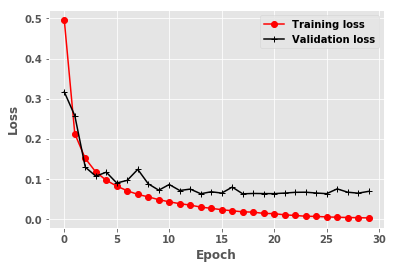

In [167]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots()

ax.plot(train_losses, color='red', marker='o', label='Training loss')
ax.plot(test_losses, color='black', marker='+', label='Validation loss')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

plt.show();

### 12. Dropout

Use `nn.Dropout(p=0.2)` to drop nodes with a probability of 0.2

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `model.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `model.train()`. In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

In [169]:
from tqdm import tqdm 
from time import time

epochs = 30
steps = 0

model = nn.Sequential(nn.Linear(784, 256),
                      nn.ReLU(),
                      nn.Dropout(p=0.2),
                      nn.Linear(256, 64),
                      nn.ReLU(),
                      nn.Dropout(p=0.2),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    start = time()
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        ## Implement the validation pass and print out the validation accuracy
        with torch.no_grad():
            for images_val, labels_val in testloader:
                images_val = images_val.view(images_val.shape[0], -1)
                log_ps_val = model(images_val)            
                test_loss += criterion(log_ps_val, labels_val)

                ps = torch.exp(log_ps_val)
                top_ps, top_classes = ps.topk(1, dim=1)
                equals = top_classes == labels_val.view(*top_classes.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        end = time()
        running_time = end-start
        
        print(f'Epoch {e+1} took {running_time:.1f}s',
              f'Training loss: {train_losses[-1]:.2f}',
              f'Testing loss: {test_losses[-1]:.2f}',
              f'Testing accuracy: {(accuracy/len(testloader))*100}%')

Epoch 1 took 28.6s Training loss: 0.58 Testing loss: 0.35 Testing accuracy: 89.27149963378906%
Epoch 2 took 27.8s Training loss: 0.27 Testing loss: 0.22 Testing accuracy: 93.3917236328125%
Epoch 3 took 29.4s Training loss: 0.21 Testing loss: 0.21 Testing accuracy: 93.61067199707031%
Epoch 4 took 29.8s Training loss: 0.17 Testing loss: 0.17 Testing accuracy: 94.53622436523438%
Epoch 5 took 30.1s Training loss: 0.15 Testing loss: 0.16 Testing accuracy: 94.92436218261719%
Epoch 6 took 26.6s Training loss: 0.13 Testing loss: 0.13 Testing accuracy: 95.96935272216797%
Epoch 7 took 26.4s Training loss: 0.12 Testing loss: 0.13 Testing accuracy: 95.97929382324219%
Epoch 8 took 26.8s Training loss: 0.11 Testing loss: 0.12 Testing accuracy: 96.52667236328125%
Epoch 9 took 27.0s Training loss: 0.10 Testing loss: 0.11 Testing accuracy: 96.5963363647461%
Epoch 10 took 26.0s Training loss: 0.09 Testing loss: 0.12 Testing accuracy: 96.47691345214844%
Epoch 11 took 25.5s Training loss: 0.09 Testing los

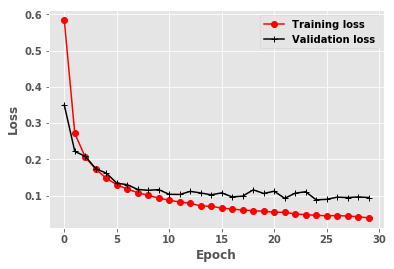

In [170]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots()

ax.plot(train_losses, color='red', marker='o', label='Training loss')
ax.plot(test_losses, color='black', marker='+', label='Validation loss')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

plt.show();

<hr>